In [3]:
%matplotlib inline


# Tensor transforms and JIT

This example illustrates various features that are now supported by the
`image transformations <transforms>` on Tensor images. In particular, we
show how image transforms can be performed on GPU, and how one can also script
them using JIT compilation.

Prior to v0.8.0, transforms in torchvision have traditionally been PIL-centric
and presented multiple limitations due to that. Now, since v0.8.0, transforms
implementations are Tensor and PIL compatible and we can achieve the following
new features:

- transform multi-band torch tensor images (with more than 3-4 channels)
- torchscript transforms together with your model for deployment
- support for GPU acceleration
- batched transformation such as for videos
- read and decode data directly as torch tensor with torchscript support (for PNG and JPEG image formats)

<div class="alert alert-info"><h4>Note</h4><p>These features are only possible with **Tensor** images.</p></div>


In [4]:
#pip install torchvision

In [5]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import onnxruntime 
import torch
import torchvision
import torchvision.transforms as T
from torchvision.io import read_image
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor, Lambda


plt.rcParams["savefig.bbox"] = 'tight'
torch.manual_seed(1)


def show(imgs):
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = T.ToPILImage()(img.to('cpu'))
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [6]:
tf = transforms.Compose([ 
        transforms.ToTensor() 
        
    ])

petdataset = torchvision.datasets.ImageFolder(root='assets', transform=tf, target_transform=None)


The :func:`~torchvision.io.read_image` function allows to read an image and
directly load it as a tensor



torch.ByteTensor


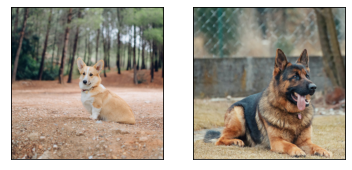

In [7]:
dog1 = read_image(str(Path('assets') / 'dog1.jpg'))
dog2 = read_image(str(Path('assets') / 'dog2.jpg'))

print(dog1.type())

show([dog1, dog2])

## Transforming images on GPU
Most transforms natively support tensors on top of PIL images (to visualize
the effect of the transforms, you may refer to see
`sphx_glr_auto_examples_plot_transforms.py`).
Using tensor images, we can run the transforms on GPUs if cuda is available!



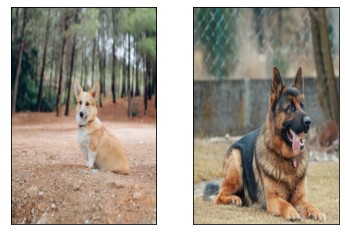

In [8]:
import torch.nn as nn

transforms2 = T.Compose([
     T.Resize((500, 334)),
     T.ConvertImageDtype(torch.float32)
 ])

device = 'cuda' if torch.cuda.is_available() else 'cpu'
dog1 = dog1.to(device)
dog2 = dog2.to(device)

transformed_dog1 = transforms2(dog1)
transformed_dog2 = transforms2(dog2)
show([transformed_dog1, transformed_dog2])

## Scriptable transforms for easier deployment via torchscript
We now show how to combine image transformations and a model forward pass,
while using ``torch.jit.script`` to obtain a single scripted module.

Let's define a ``Predictor`` module that transforms the input tensor and then
applies an ImageNet model on it.



In [9]:
from torchvision.models import resnet18


class Predictor(nn.Module):

    def __init__(self):
        super().__init__()
        self.resnet18 = resnet18(pretrained=True, progress=False).eval()
        self.transforms = nn.Sequential(
            T.RandomCrop([256, ]),  # We use single int value inside a list due to torchscript type restrictions
            T.CenterCrop(224),
            T.ConvertImageDtype(torch.float32),
            T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
    #def forward(self, x):
        with torch.no_grad():
            x = self.transforms(x)
            y_pred = self.resnet18(x)
            return y_pred.argmax(dim=1)

Now, let's define scripted and non-scripted instances of ``Predictor`` and
apply it on multiple tensor images of the same size



In [10]:
predictor = Predictor().to(device)
scripted_predictor = torch.jit.script(predictor).to(device)

batch = torch.stack([transformed_dog1, transformed_dog2]).to(device)

res = predictor(batch)
res_scripted = scripted_predictor(batch)

We can verify that the prediction of the scripted and non-scripted models are
the same:



In [11]:
import json

with open(Path('assets') / 'imagenet_class_index.json') as labels_file:
    labels = json.load(labels_file)

for i, (pred, pred_scripted) in enumerate(zip(res, res_scripted)):
    assert pred == pred_scripted
    print("idx: ", pred.item())
    print(f"Prediction for Dog {i + 1}: {labels[str(pred.item())]}")


idx:  263
Prediction for Dog 1: ['n02113023', 'Pembroke']
idx:  235
Prediction for Dog 2: ['n02106662', 'German_shepherd']


Save model

In [12]:
import torch.onnx
from torchvision import models



predictor = models.__dict__['resnet18'](pretrained=True)

torch.save(predictor.state_dict(), 'model.pth')

input_size = torch.zeros((1, 3, 500, 334))  

predictor.eval()
torch.onnx.export(predictor, input_size, 'output/model.onnx', export_params=True, opset_version=13)

In [20]:
#transformed_dog1 = transformed_dog1.type(torch.FloatTensor)

batch = torch.stack([transformed_dog1]).to(device)
          
session = onnxruntime.InferenceSession('output/model.onnx')
input_name = session.get_inputs()[0].name
output_name = session.get_outputs()[0].name

result = session.run([output_name], {input_name: batch.numpy()})
temp = result[0][0]

print("predicted idx: ", result[0][0].argmax(0))
print("predicted for dog1: ", labels[str(result[0][0].argmax(0))])
#predicte"predicted idx: ", d, actual = classes[result[0][0].argmax(0)], classes[y]
#print(f'Predicted: "{predicted}", Actual: "{actual}"')


predicted idx:  273
predicted for dog1:  ['n02115641', 'dingo']


In [14]:
session = onnxruntime.InferenceSession('output/model.onnx')

input_name = session.get_inputs()[0].name
output_name = session.get_outputs()[0].name

result = session.run([output_name], {input_name: batch.numpy()})

temp = result[0][0]
idx = result[0][0].argmax(0)
print("predicted value: ", temp[idx])
print("predicted idx: ", result[0][0].argmax(0))
print("predict for dog1: ",labels[str(result[0][0].argmax(0))])

predicted idx:  5.086276
predicted value:  273
['n02115641', 'dingo']


In [15]:
#onnxruntime.__version__


In [16]:
#!pip install onnxruntime --upgradec

In [17]:
#!pip uninstall onnxruntime